In [1]:
import numpy as np
from random import randrange as r
import random 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.animation import FuncAnimation
from matplotlib.image import imread
from numba import njit
import time
from scipy.spatial.distance import cdist,pdist,squareform

Elapsed (with compilation) = 3.347012519836426
Elapsed (after compilation) = 0.4173731803894043


<IPython.core.display.Javascript object>


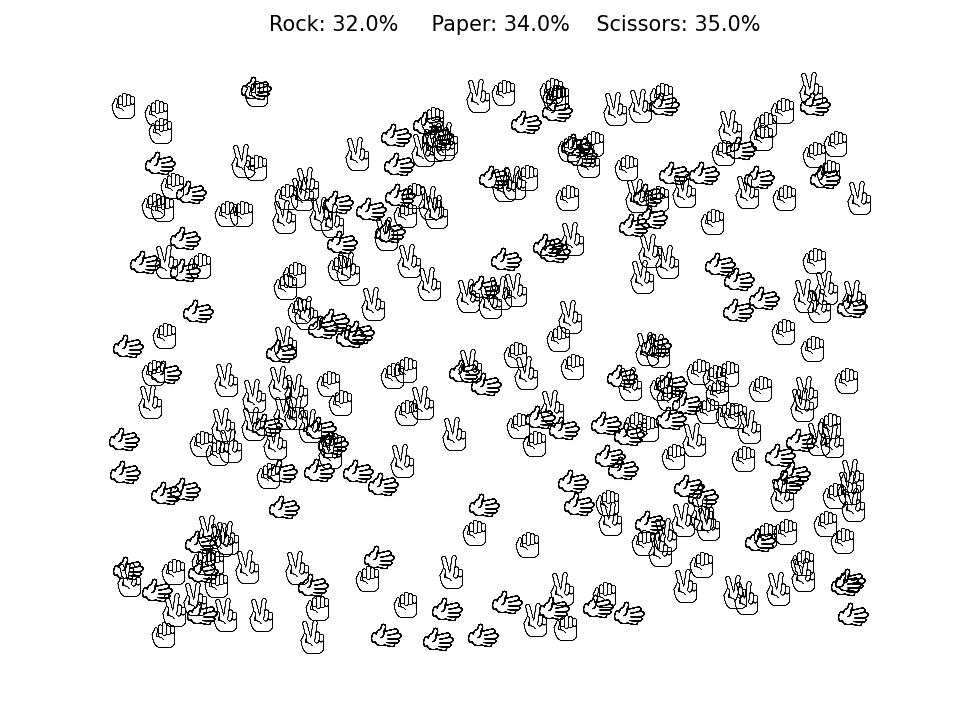

In [2]:
%matplotlib notebook
class rps_object():
    def __init__(self,xlim,ylim):
        self.x_pos = np.random.uniform(-xlim,xlim)
        self.y_pos = np.random.uniform(-ylim,ylim)
        self.vx = np.random.uniform(-xlim,xlim)/50
        self.vy = np.random.uniform(-ylim,ylim)/50
        self.x_list = []
        self.y_list = []
        self.state = random.choice(['Rock','Paper','Scissor'])
        self.state_list = []
@njit
def rps_winner(player_choice, opponent_choice):
    choices = {'Rock': 0, 'Paper': 1, 'Scissor': 2}
    return (choices[player_choice]-choices[opponent_choice]) % 3

def simulater(n,xlim,ylim):
    threshold = 0.2
    t = 0
    dt = 0.03
    object_list = [rps_object(xlim,ylim) for i in range(n)]
    while t < 10:
        #OBJECT COLLISION
        XY = np.array([(N.x_pos,N.y_pos) for N in object_list])
        dist_matrix = cdist(XY,XY)
        mask = (dist_matrix < threshold) & (dist_matrix > 0)
        close_pairs = np.argwhere(mask)
        if len(close_pairs) > 0:
            for i, j in close_pairs:
                if object_list[j].state != object_list[i].state:
                    if rps_winner(object_list[i].state,object_list[j].state) == 1:
                        object_list[j].state = object_list[i].state
                    else:
                        object_list[i].state = object_list[j].state
                    object_list[i].vx, object_list[i].vy = -object_list[i].vx, -object_list[i].vy
                    object_list[j].vx, object_list[j].vy = -object_list[j].vx, -object_list[j].vy
        dist_matrix = 0
        for objects in object_list:
            #BOARDER COLLISION
            if objects.x_pos > xlim or objects.x_pos < -xlim:
                objects.vx = -objects.vx
            if objects.y_pos > ylim or objects.y_pos < -ylim:
                objects.vy = -objects.vy
            objects.x_pos += objects.vx
            objects.y_pos += objects.vy
            objects.x_list.append(objects.x_pos)
            objects.y_list.append(objects.y_pos)
            objects.state_list.append(objects.state)
        t+=dt
    return object_list
xlim = 10
ylim = 10
n = 300

start = time.time()
test = simulater(n,xlim,ylim)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

start = time.time()
test = simulater(n,xlim,ylim)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

fig,ax = plt.subplots()
plt.xlim(-xlim,xlim)
plt.ylim(-ylim,ylim)
length = len(test)

fig_files = ['Rock.png', 'Paper.png', 'Scissor.png']
figures = [imread(fig_file) for fig_file in fig_files]

distribution = ax.text(-6,12,f'Rock:{0}, Paper:{0}, Scissors:{0},')
ann_boxes = []
for j in range(length):
    ab = AnnotationBbox(OffsetImage(figures[0], zoom=0.08), (0,0), xycoords='data', frameon=False)
    ann_boxes.append(ab)
    ax.add_artist(ab)
img = None 
def ani(i):
    R_p = 0
    P_p = 0
    S_p = 0
    for j in range(length):
        if test[j].state_list[i] == 'Rock':
            R_p += 1
            img = figures[0]
        elif test[j].state_list[i] == 'Paper':
            P_p += 1
            img = figures[1]
        elif test[j].state_list[i] == 'Scissor':
            S_p += 1
            img = figures[2]
        xy = (test[j].x_list[i], test[j].y_list[i]) 
        ann_boxes[j].remove()
        ann_boxes[j].xy = xy
        ab = AnnotationBbox(OffsetImage(img, zoom=0.08), xy, xycoords='data', frameon=False)
        ann_boxes[j] = ax.add_artist(ab)  # Add the new artist
    distribution.set_text(f'Rock: {np.round(100*R_p/length)}%     Paper: {np.round(100*P_p/length)}%    Scissors: {np.round(100*S_p/length)}%')
    return ann_boxes,distribution

animation = FuncAnimation(fig, func=ani, frames=np.arange(0, len(test[0].x_list), 1), interval=100,blit=True)
plt.axis('off')
plt.show();

In [4]:
animation.save('animation.gif', writer='imagemagick', fps=60)

MovieWriter imagemagick unavailable; using Pillow instead.
